In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/BINAR DSC18-3/train_preprocess.tsv.txt', sep='	', header=None, names=['teks', 'label'])
df.shape

(11000, 2)

In [3]:
df.label.value_counts()

label
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

In [4]:
df.head()

,teks,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


## CLEANSING

In [5]:
import re

def cleansing (text):
    string = text.lower()
    string = re.sub(r'[^a-zA-Z0-9]',' ', string)
    return string

In [6]:
df['teksclean']=df.teks.apply(cleansing)
df.head()

,teks,label,teksclean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung t...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kas...


In [7]:
neg = df.loc[df['label'] == 'negative'].teksclean.tolist()
neu = df.loc[df['label'] == 'neutral'].teksclean.tolist()
pos = df.loc[df['label'] == 'positive'].teksclean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

In [8]:
totaldata = neg + neu + pos
labels = neg_label + neu_label + pos_label

print("Neg: %s, Neu: %s, Pos: %s" %(len(neg), len(neu), len(pos)))
print("Total data: %s" %len(totaldata))

Neg: 3436, Neu: 1148, Pos: 6416
Total data: 11000


## FEATURE EXTRACTION

In [9]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

In [10]:
max_features = 1000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(totaldata)
with open ('tokenizer.pickle','wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print ("tokenizer.pickle has created")

X = tokenizer.texts_to_sequences(totaldata)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open ('x_pad_sequences.pickle','wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('x_pad_sequences.pickle has created')

tokenizer.pickle has created
x_pad_sequences.pickle has created


In [11]:
Y = pd.get_dummies(labels)
Y = Y.values

with open ('y_labels.pickle','wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('y_labels.pickle has created')

y_labels.pickle has created


In [12]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)

In [ ]:
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

17272

In [ ]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

## LSTM

In [13]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras import backend as K
import keras

In [14]:
embed_dim = 16
units = 128

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_shape=(X.shape[1],)))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(units, return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(Dense(3,activation='softmax'))
#model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics =['accuracy'])

opt = optimizers.Adam(learning_rate = 0.001)
model.compile(loss= 'categorical_crossentropy', optimizer=opt, metrics =['accuracy'])
print(model.summary())

#es = EarlyStopping (monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=5, batch_size=256, validation_data=(X_test, y_test), verbose=1)
#callbacks=[es]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 82, 16)            16000     
                                                                 
 spatial_dropout1d (Spatial  (None, 82, 16)            0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 90627 (354.01 KB)
Trainable params: 90627 (354.01 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [15]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print ("TESTING SELESAI")
print(matrix_test)

69/69 [==============================] - 4s 48ms/step
TESTING SELESAI
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       704
           1       0.54      0.75      0.63       222
           2       0.90      0.89      0.89      1274

    accuracy                           0.82      2200
   macro avg       0.75      0.79      0.76      2200
weighted avg       0.83      0.82      0.82      2200



In [ ]:
#coba predict datatrain
predictions = model.predict(X_train)
y_pred = predictions
matrix_test1 = metrics.classification_report(y_train.argmax(axis=1), y_pred.argmax(axis=1))
print ("TESTING SELESAI")
print(matrix_test1)

275/275 [==============================] - 17s 62ms/step
TESTING SELESAI
              precision    recall  f1-score   support

           0       0.72      0.90      0.80      2732
           1       0.78      0.40      0.53       926
           2       0.94      0.90      0.92      5142

    accuracy                           0.85      8800
   macro avg       0.82      0.73      0.75      8800
weighted avg       0.86      0.85      0.84      8800



## CROSS VALIDATION

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []
y = Y

for iteration, data in enumerate(kf.split(X), start=1):
    data_train = X[data[0]]
    target_train = y[data[0]]

    data_test = X[data[1]]
    target_test = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_shape=(X.shape[1],)))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(units, return_sequences=False))
    model.add(layers.Dropout(0.2))
    model.add(Dense(3,activation='softmax'))
    #model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    opt = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics =['accuracy'])

    #es = EarlyStopping (monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=5, batch_size=256, validation_data=(X_test, y_test), verbose=0)
    #verbose 1 menjadi 0

    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    #metrics report menjadi accuracy score

    print ('Training ke-', iteration)
    print (classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print ('===================================================================')

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print('Rata-rata Accuracy:', average_accuracy)


69/69 [==============================] - 4s 49ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       704
           1       0.68      0.66      0.67       222
           2       0.91      0.89      0.90      1274

    accuracy                           0.84      2200
   macro avg       0.79      0.78      0.78      2200
weighted avg       0.84      0.84      0.84      2200

69/69 [==============================] - 4s 55ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.72      0.84      0.77       704
           1       0.71      0.53      0.61       222
           2       0.91      0.87      0.89      1274

    accuracy                           0.82      2200
   macro avg       0.78      0.74      0.76      2200
weighted avg       0.83      0.82      0.82      2200

69/69 [==============================] - 5s 69ms/step
Training ke- 3
              precision    reca

## MODELLING

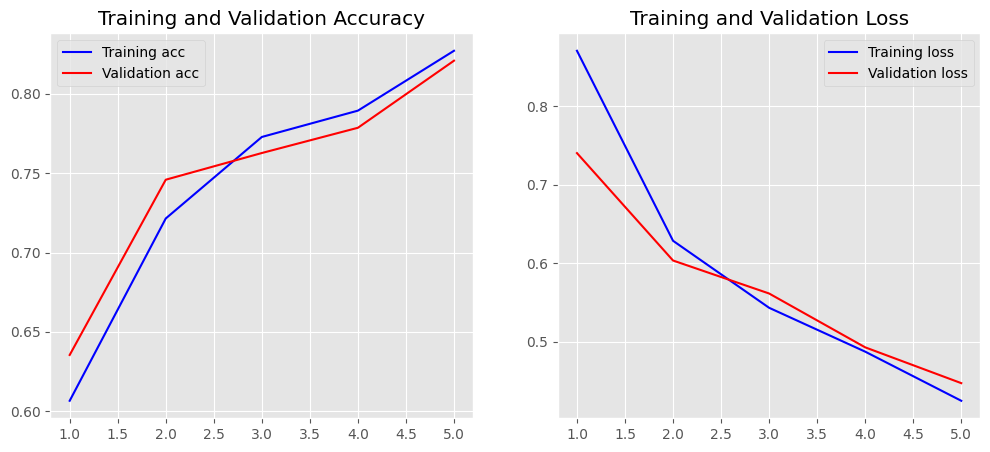

In [20]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plothist (history):
    acc = history.history ['accuracy']
    val_acc = history.history ['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) +1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title ('Training and Validation Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title ('Training and Validation Loss')
    plt.legend()

%matplotlib inline
plothist (history)


In [21]:
model.save('model-lstm-v2.h5')
print ('Model has created')

Model has created


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## PREDICT

In [23]:
from keras.models import load_model

input_text = """
jangan kecewa pada tuhan
"""

def cleansing (input):
    string = input.lower()
    string = re.sub(r'[^a-zA-Z0-9]',' ', string)
    return string

sentiment = ['negative','neutral','positive']

teks = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(teks)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model-lstm-v2.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('Teks: ', teks[0])
print('Sentiment: ', sentiment[polarity])

1/1 [==============================] - 2s 2s/step
Teks:   jangan kecewa pada tuhan 
Sentiment:  negative


In [ ]:
polarity

1